In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Data Understanding

## Load the training and testing data

In [ ]:
# Install necessary libraries and mount Google Drive
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up Kaggle credentials to download the dataset

# Make sure the .kaggle directory exists
!mkdir -p ~/.kaggle  # -p ensures no error if directory already exists

!cp /content/drive/MyDrive/WiDS_Data/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c widsdatathon2025
!unzip widsdatathon2025.zip

Archive:  widsdatathon2025.zip
  inflating: Data Dictionary.xlsx    
  inflating: SAMPLE_SUBMISSION.xlsx  
  inflating: TEST/TEST_CATEGORICAL.xlsx  
  inflating: TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv  
  inflating: TEST/TEST_QUANTITATIVE_METADATA.xlsx  
  inflating: TRAIN_NEW/TRAINING_SOLUTIONS.xlsx  
  inflating: TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx  
  inflating: TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv  
  inflating: TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx  
  inflating: TRAIN_OLD/TRAINING_SOLUTIONS.xlsx  
  inflating: TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx  
  inflating: TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv  
  inflating: TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx  


In [ ]:
# Read the categorical training data
file_path_trainC = 'TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx'
train_cat = pd.read_excel(file_path_trainC)
train_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0


In [ ]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [ ]:
# Read the FCM training data
file_path_trainFCM = 'TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv'
train_FCM = pd.read_csv(file_path_trainFCM)
train_FCM.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269


In [ ]:
train_FCM.columns

Index(['participant_id', '0throw_1thcolumn', '0throw_2thcolumn',
       '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn',
       '0throw_6thcolumn', '0throw_7thcolumn', '0throw_8thcolumn',
       '0throw_9thcolumn',
       ...
       '195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn',
       '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn',
       '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn',
       '198throw_199thcolumn'],
      dtype='object', length=19901)

In [ ]:
# Read the quantitative training data
file_path_trainQ = 'TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx'
train_Quant = pd.read_excel(file_path_trainQ)
train_Quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679


In [ ]:
train_Quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [ ]:
# Read the ADHD and Sex solutions training data
file_path_trainS = 'TRAIN_OLD/TRAINING_SOLUTIONS.xlsx'
train_Solutions = pd.read_excel(file_path_trainS)
train_Solutions.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [ ]:
# Read categorical testing data
file_path_testC = 'TEST/TEST_CATEGORICAL.xlsx'
test_cat = pd.read_excel(file_path_testC)
test_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


In [ ]:
# Read FCM testing data
file_path_testFCM = 'TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv'
test_FCM = pd.read_csv(file_path_testFCM)
test_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


In [ ]:
# Read quantitative testing data
file_path_testQ = 'TEST/TEST_QUANTITATIVE_METADATA.xlsx'
test_Quant = pd.read_excel(file_path_testQ)
test_Quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


## Exploratory Data Analysis

In [ ]:
train_Solutions.columns

Index(['participant_id', 'ADHD_Outcome', 'Sex_F'], dtype='object')

In [ ]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 5   MRI_Track_Scan_Location           1213 non-null   int64  
 6   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 7   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 8   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 9   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 94.9+ KB


In [ ]:
# DISTRIBUTION OF CATEGORICAL VARIABLES
# Barratt_Barratt_P2_Occ - Barratt Simplified Measure of Social Status - Parent 2 Occupation
train_cat['Barratt_Barratt_P2_Occ'].value_counts()

# Look back at the dictionary on Kaggle!
# to see what category these integers [0, 45, 35...] represent.

,count
Barratt_Barratt_P2_Occ,
0,287
45,239
35,195
30,149
40,116
15,86
20,41
5,38
10,37


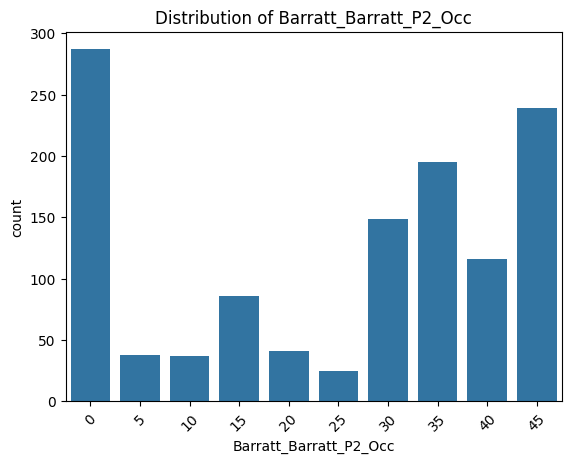

In [ ]:
# VISUALIZE DISTRIBUTIONS
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat[['Barratt_Barratt_P2_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.xticks(rotation=45)
plt.show()

The above analysis show that 'Barratt_Barratt_P2_OCC' is highly imbalanced.

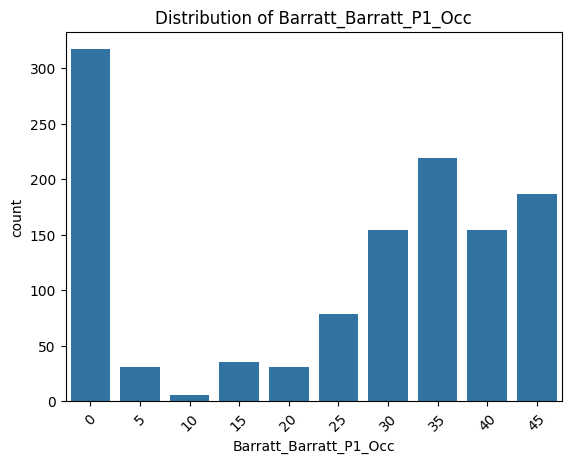

In [ ]:
sns.countplot(x='Barratt_Barratt_P1_Occ', data=train_cat[['Barratt_Barratt_P1_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P1_Occ")
plt.xticks(rotation=45)
plt.show()

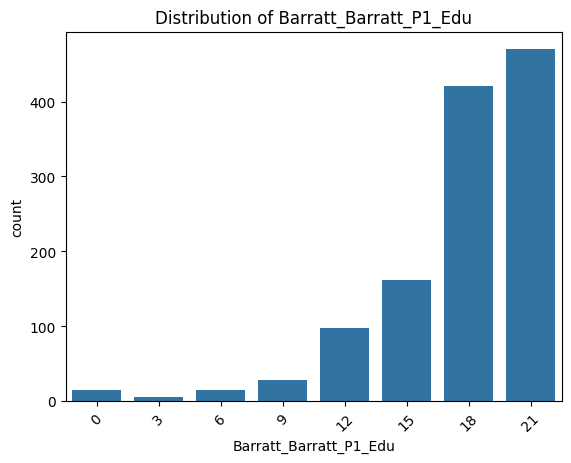

In [ ]:
sns.countplot(x='Barratt_Barratt_P1_Edu', data=train_cat[['Barratt_Barratt_P1_Edu']])
plt.title(f"Distribution of Barratt_Barratt_P1_Edu")
plt.xticks(rotation=45)
plt.show()

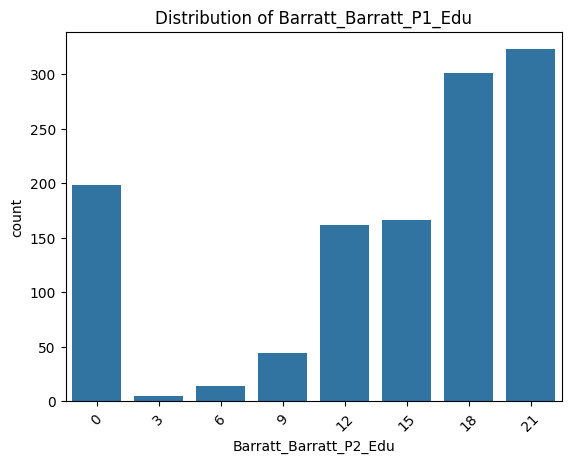

In [ ]:
sns.countplot(x='Barratt_Barratt_P2_Edu', data=train_cat[['Barratt_Barratt_P2_Edu']])
plt.title(f"Distribution of Barratt_Barratt_P1_Edu")
plt.xticks(rotation=45)
plt.show()

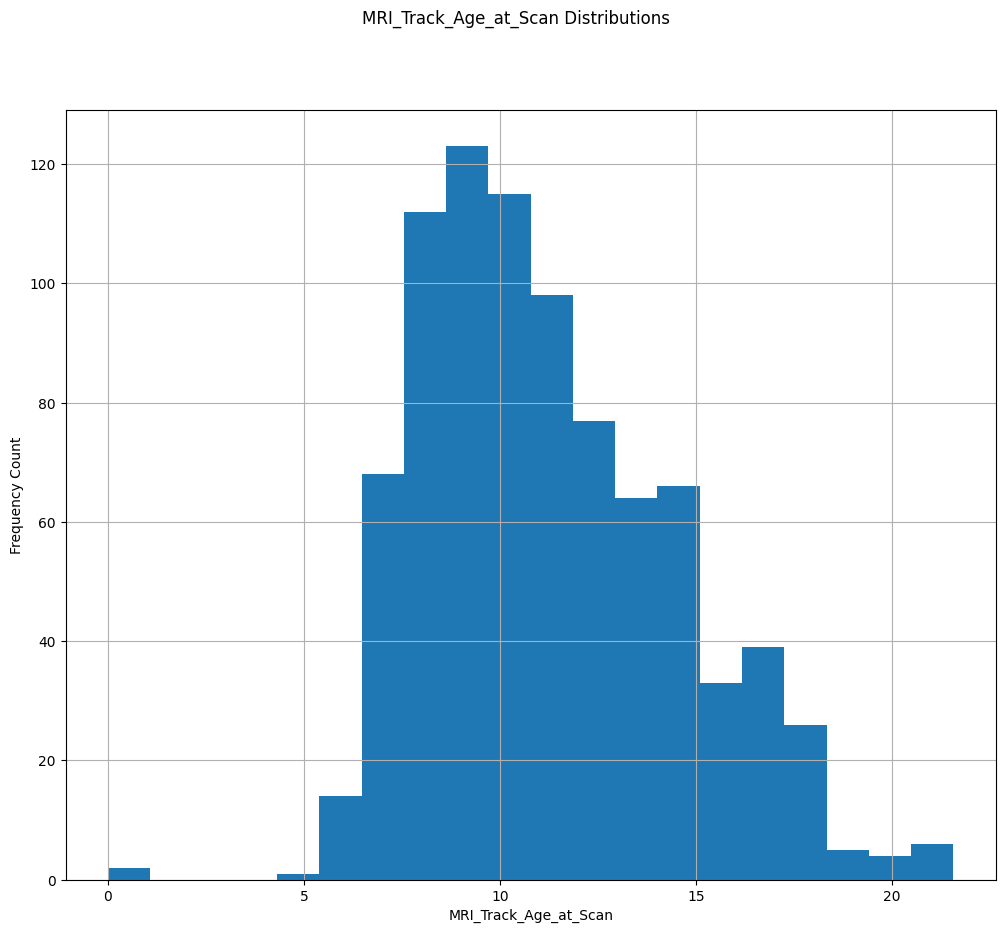

In [ ]:
# Distribution of MRI_Track_Age_at_Scan
train_Quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

In [ ]:
# CLASS DISTRIBUTION: ADHD distribution
train_Solutions['ADHD_Outcome'].value_counts()

,count
ADHD_Outcome,
1,831
0,382


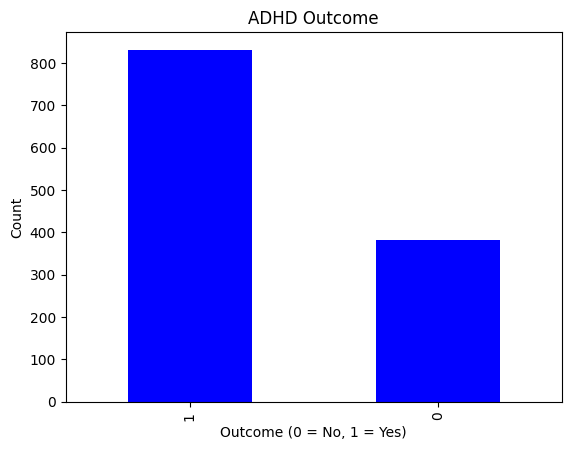

In [ ]:
train_Solutions['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Gender distribution
train_Solutions['Sex_F'].value_counts()

,count
Sex_F,
0,797
1,416


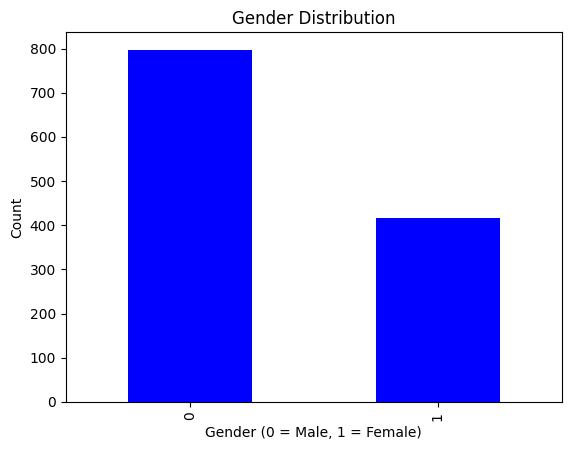

In [ ]:
train_Solutions['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

#THERE IS A GENDER IMBALANCE THAT WE NEED TO ADDRESS
#Tanvi and Paige will work on this

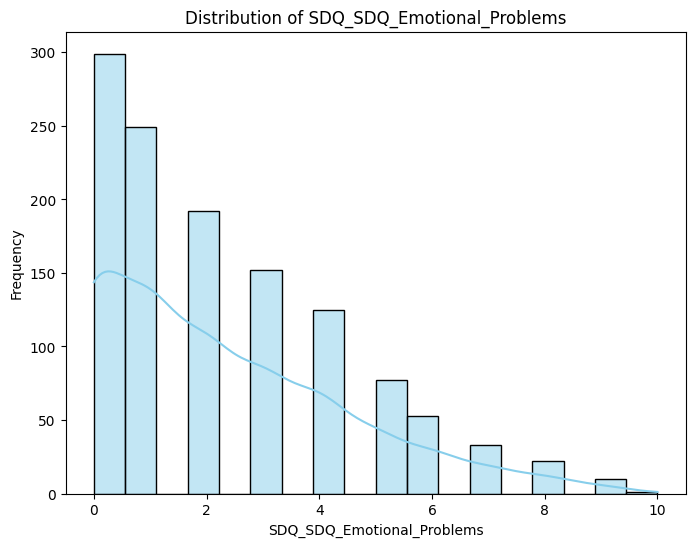

In [ ]:
# VISUALIZE DISTRIBUTIONS OF QUANTITATIVE PROBLEMS
train_Quant.columns

# Plot the distribution of the SDQ_SDQ_Emotional_Problems variable
plt.figure(figsize=(8, 6))
sns.histplot(train_Quant['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()

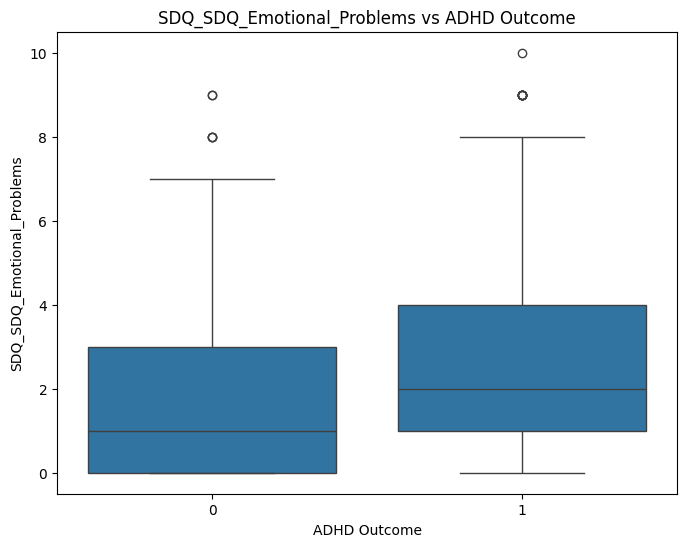

In [ ]:
# Check for correlation with ADHD outcome
train_Quant_copy = train_Quant.copy()
train_Quant_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Emotional_Problems', data=train_Quant_copy)
plt.title('SDQ_SDQ_Emotional_Problems vs ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('SDQ_SDQ_Emotional_Problems')
plt.show()

##### **Categorical Data**: Use bar plots to compare groups (e.g., ADHD rates by Parent 1 occupation).


In [ ]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

Let's look at `Barratt_Barratt_P1_Edu` which indicates the Parent 1 level of education

- 3=Less than 7th grade
- 6=Junior high/Middle school (9th grade)
- 9=Partial high school (10th or 11th grade)
- 12=High school graduate
- 15=Partial college (at least one year)
- 18=College education
- 21=Graduate degree

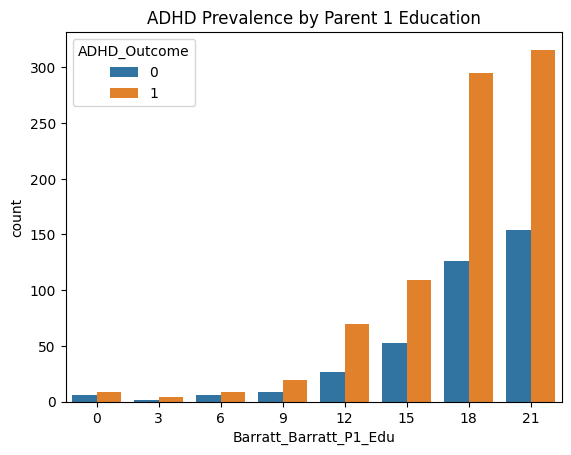

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_cat, x='Barratt_Barratt_P1_Edu', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 1 Education')
plt.show()

In [ ]:
train_cat['Barratt_Barratt_P1_Edu'].value_counts()

,count
Barratt_Barratt_P1_Edu,
21,470
18,421
15,162
12,97
9,28
0,15
6,15
3,5


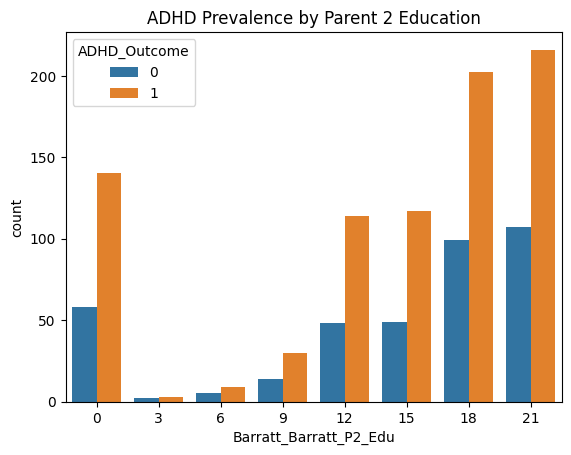

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_cat, x='Barratt_Barratt_P2_Edu', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 2 Education')
plt.show()

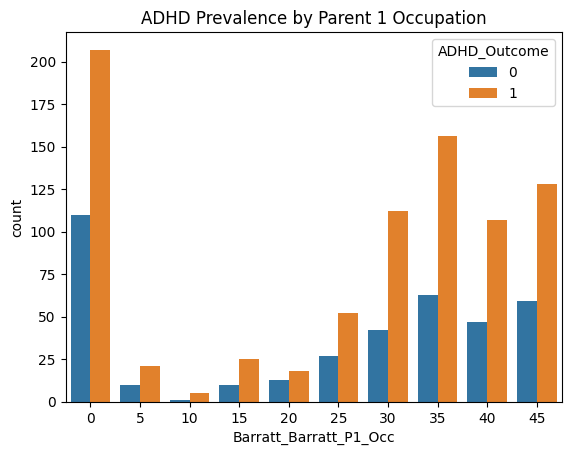

In [ ]:
sns.countplot(data=train_cat, x='Barratt_Barratt_P1_Occ', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 1 Occupation')
plt.show()

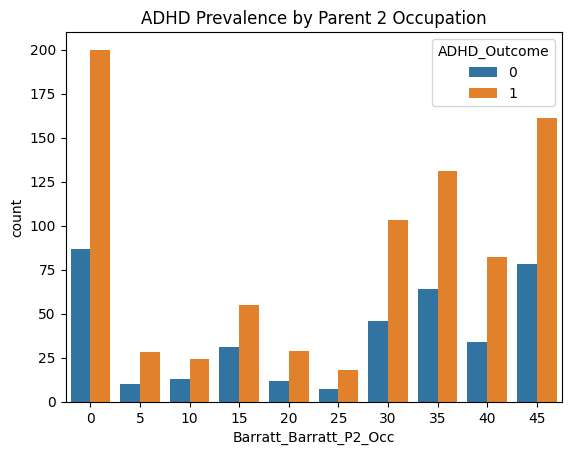

In [ ]:
sns.countplot(data=train_cat, x='Barratt_Barratt_P2_Occ', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 2 Occupation')
plt.show()

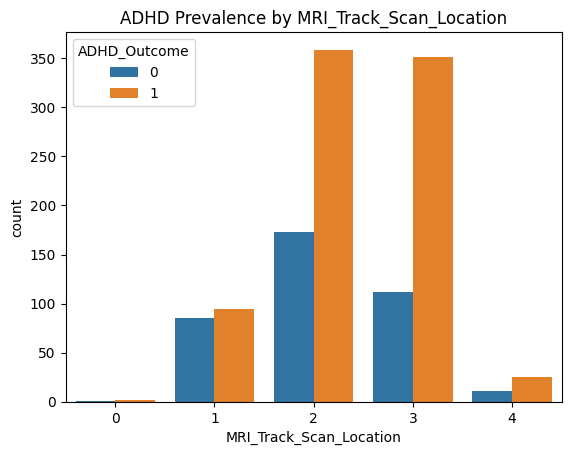

In [ ]:
sns.countplot(data=train_cat, x='MRI_Track_Scan_Location', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by MRI_Track_Scan_Location')
plt.show()

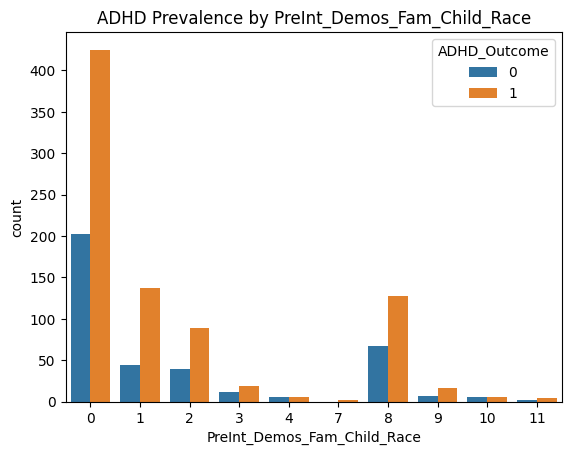

In [ ]:
sns.countplot(data=train_cat, x='PreInt_Demos_Fam_Child_Race', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by PreInt_Demos_Fam_Child_Race')
plt.show()

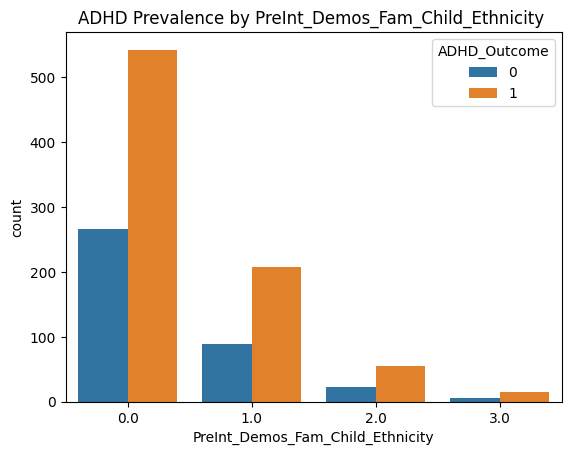

In [ ]:
sns.countplot(data=train_cat, x='PreInt_Demos_Fam_Child_Ethnicity', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by PreInt_Demos_Fam_Child_Ethnicity ')
plt.show()


Number of missing values in categorical data

In [ ]:
# Count the number of missing values per column
missing_values = train_cat.isnull().sum()

# Calculate the percentage of missing values
missing_percentage = (missing_values / len(train_cat)) * 100

# Combine into a DataFrame for better readability
missing_df = pd.DataFrame({'Missing_Values': missing_values, 'Missing_Percentage': missing_percentage})

print(missing_df)


                                  Missing_Values  Missing_Percentage
participant_id                                 0            0.000000
Basic_Demos_Enroll_Year                        0            0.000000
Basic_Demos_Study_Site                         0            0.000000
PreInt_Demos_Fam_Child_Ethnicity              11            0.906843
PreInt_Demos_Fam_Child_Race                    0            0.000000
MRI_Track_Scan_Location                        0            0.000000
Barratt_Barratt_P1_Edu                         0            0.000000
Barratt_Barratt_P1_Occ                         0            0.000000
Barratt_Barratt_P2_Edu                         0            0.000000
Barratt_Barratt_P2_Occ                         0            0.000000


In [ ]:
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

def cramers_v(contingency_table):
    """Calculate Cramér’s V statistic for categorical-categorical correlation."""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * k))

# Load your dataset (ensure `train_cat` and `train_Solutions` are merged)
# Assuming 'Sex_F' and 'ADHD_Outcome' are binary categorical variables (0 or 1)

categorical_columns = [
    "Basic_Demos_Enroll_Year", "Basic_Demos_Study_Site",
    "PreInt_Demos_Fam_Child_Ethnicity", "PreInt_Demos_Fam_Child_Race",
    "MRI_Track_Scan_Location", "Barratt_Barratt_P1_Edu",
    "Barratt_Barratt_P1_Occ", "Barratt_Barratt_P2_Edu", "Barratt_Barratt_P2_Occ"
]

correlation_results = {}

for col in categorical_columns:
    contingency_table_sex = pd.crosstab(train_cat[col], train_Solutions['Sex_F'])
    contingency_table_adhd = pd.crosstab(train_cat[col], train_Solutions['ADHD_Outcome'])

    # Compute Cramér’s V
    sex_corr = cramers_v(contingency_table_sex)
    adhd_corr = cramers_v(contingency_table_adhd)

    correlation_results[col] = {'Sex_Correlation': sex_corr, 'ADHD_Correlation': adhd_corr}

# Convert results to DataFrame for easier analysis
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')

print(correlation_df)

                                  Sex_Correlation  ADHD_Correlation
Basic_Demos_Enroll_Year                  0.059113          0.196727
Basic_Demos_Study_Site                   0.054425          0.093208
PreInt_Demos_Fam_Child_Ethnicity         0.029350          0.036956
PreInt_Demos_Fam_Child_Race              0.072240          0.086997
MRI_Track_Scan_Location                  0.080686          0.164804
Barratt_Barratt_P1_Edu                   0.092478          0.048577
Barratt_Barratt_P1_Occ                   0.082118          0.071458
Barratt_Barratt_P2_Edu                   0.092889          0.040225
Barratt_Barratt_P2_Occ                   0.084711          0.045700


# Data Cleaning and Preprocessing

## Preliminary handling of missing data

In [ ]:
def handle_missing_values(df):
    # Display the count of missing values per column
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]

    if not missing_cols.empty:
        print("Missing values before handling:")
        print(missing_cols)
    else:
        print("No missing values detected.")
        return df  # No changes needed

    # Create a copy of the DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Handle missing data based on column type
    df_cleaned.update(df_cleaned.select_dtypes(include=['category']).apply(lambda x: x.fillna(x.mode()[0])))
    df_cleaned.update(df_cleaned.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.fillna(x.median())))

    # Confirm that missing values are removed
    if df_cleaned.isnull().sum().sum() == 0:
        print("All missing values have been filled.")
    else:
        print("Some missing values remain. Check data types and handling logic.")

    return df_cleaned

In [ ]:
# Handle missing values in training data
train_cat = handle_missing_values(train_cat)
train_Quant = handle_missing_values(train_Quant)
train_FCM = handle_missing_values(train_FCM)
train_Solutions = handle_missing_values(train_Solutions)

Missing values before handling:
PreInt_Demos_Fam_Child_Ethnicity    11
dtype: int64
All missing values have been filled.
Missing values before handling:
MRI_Track_Age_at_Scan    360
dtype: int64
All missing values have been filled.
No missing values detected.
No missing values detected.


In [ ]:
# Handle missing values in testing data
test_cat = handle_missing_values(test_cat)
test_Quant = handle_missing_values(test_Quant)
test_FCM = handle_missing_values(test_FCM)

Missing values before handling:
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
Barratt_Barratt_P1_Edu               1
Barratt_Barratt_P1_Occ               1
Barratt_Barratt_P2_Edu              36
Barratt_Barratt_P2_Occ              42
dtype: int64
All missing values have been filled.
Missing values before handling:
EHQ_EHQ_Total                  1
ColorVision_CV_Score           9
APQ_P_APQ_P_CP                15
APQ_P_APQ_P_ID                15
APQ_P_APQ_P_INV               15
APQ_P_APQ_P_OPD               15
APQ_P_APQ_P_PM                15
APQ_P_APQ_P_PP                15
SDQ_SDQ_Conduct_Problems      30
SDQ_SDQ_Difficulties_Total    30
SDQ_SDQ_Emotional_Problems    30
SDQ_SDQ_Externalizing         30
SDQ_SDQ_Generating_Impact     30
SDQ_SDQ_Hyperactivity         30
SDQ_SDQ_Internalizing         30
SDQ_SDQ_Peer_Problems         30
SDQ_SDQ_Prosocial             30
dtype: int64
All missing values have been filled.
No missing values detected.


## Preprocess Categorical Data

Most of the data points fall into a specific category (e.g., 21 has 470 entries out of a total 1213). This means that even if ADHD prevalence appears higher in this category, it might just reflect that there are more people in this group overall, rather than an actual trend.

To adress this, normalize the data or compute percentages within each category to account for differences in group sizes. Let's compute ADHD percentage for each category.

For categorical variables (e.g. occupation), compute the percentages to detect imbalance.

In [ ]:
# Add ADHD_Outcome directly to a copy of the train_cat dataset for grouping
train_cat_copy = train_cat.copy()
train_cat_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

adhd_percentages = train_cat_copy.groupby('Barratt_Barratt_P1_Edu')['ADHD_Outcome'].mean().sort_values(ascending=False)
print(adhd_percentages)

Barratt_Barratt_P1_Edu
3     0.800000
12    0.721649
18    0.700713
9     0.678571
15    0.672840
21    0.672340
6     0.600000
0     0.600000
Name: ADHD_Outcome, dtype: float64


Categories like 3 - Less than 7th grade (80%) and 12 - High school graduate (72%) show some of the highest proportions of ADHD outcomes. Categories 21 - Graduate degree (67.2%) have relatively lower ADHD proportions compared to middle education levels.

While these proportions might appear noteworthy, it is essential to consider the smaller sample size for lower education levels. **Smaller sample sizes can lead to greater variability** and make the proportions more susceptible to outliers. This means that a few individual cases can disproportionately affect the results, making them less reliable and less representative of the broader population. Therefore, it is crucial to examine sample sizes carefully before drawing any conclusions.

In [ ]:
# Compute percentages within each category of P2_Edu
adhd_percentages = train_cat_copy.groupby('Barratt_Barratt_P2_Edu')['ADHD_Outcome'].mean().sort_values(ascending=False)
print(adhd_percentages)

Barratt_Barratt_P2_Edu
0     0.707071
15    0.704819
12    0.703704
9     0.681818
18    0.671096
21    0.668731
6     0.642857
3     0.600000
Name: ADHD_Outcome, dtype: float64


In [ ]:
# Compute percentages within each category of P1_Occ
adhd_percentages = train_cat_copy.groupby('Barratt_Barratt_P1_Occ')['ADHD_Outcome'].mean().sort_values(ascending=False)
print(adhd_percentages)

Barratt_Barratt_P1_Occ
10    0.833333
30    0.727273
15    0.714286
35    0.712329
40    0.694805
45    0.684492
5     0.677419
25    0.658228
0     0.652997
20    0.580645
Name: ADHD_Outcome, dtype: float64


In [ ]:
# Compute percentages within each category of P2_Occ
adhd_percentages = train_cat_copy.groupby('Barratt_Barratt_P2_Occ')['ADHD_Outcome'].mean().sort_values(ascending=False)
print(adhd_percentages)

Barratt_Barratt_P2_Occ
5     0.736842
25    0.720000
20    0.707317
40    0.706897
0     0.696864
30    0.691275
45    0.673640
35    0.671795
10    0.648649
15    0.639535
Name: ADHD_Outcome, dtype: float64


## Feature engineer the quantitative data

Calculate the correlations between features

In [ ]:
corr_matrix = train_Quant.iloc[:, 1:].corr()
corr_matrix

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
EHQ_EHQ_Total,1.000000,0.027679,-0.013414,0.019131,0.033819,-0.012423,0.049200,0.020321,-0.051240,-0.054827,-0.034221,-0.028900,-0.014712,-0.005902,-0.068243,-0.079418,-0.003058,0.063955
ColorVision_CV_Score,0.027679,1.000000,0.066965,0.022960,0.007465,0.023402,-0.013446,0.029796,0.016444,0.000335,0.010199,0.005308,0.051282,-0.003932,-0.005658,-0.020101,-0.009576,-0.061135
APQ_P_APQ_P_CP,-0.013414,0.066965,1.000000,0.315148,0.089254,0.379770,0.138122,0.151907,0.206375,0.187030,0.075342,0.212691,0.137611,0.165202,0.097718,0.086405,-0.048402,-0.051431
APQ_P_APQ_P_ID,0.019131,0.022960,0.315148,1.000000,0.063517,0.398303,0.290048,0.141616,0.262340,0.244832,0.179096,0.258515,0.260136,0.192592,0.151485,0.069351,-0.209724,0.006457
APQ_P_APQ_P_INV,0.033819,0.007465,0.089254,0.063517,1.000000,0.293751,0.036298,0.739292,-0.150160,-0.135987,-0.053424,-0.119715,-0.062042,-0.068736,-0.112399,-0.133852,0.169940,-0.046899
APQ_P_APQ_P_OPD,-0.012423,0.023402,0.379770,0.398303,0.293751,1.000000,0.172204,0.383299,0.298944,0.273078,0.134797,0.288022,0.228552,0.209824,0.169337,0.145343,-0.150646,-0.093420
APQ_P_APQ_P_PM,0.049200,-0.013446,0.138122,0.290048,0.036298,0.172204,1.000000,0.097627,0.085674,0.031272,0.052693,0.016652,0.081955,-0.036648,0.038725,0.010564,-0.048129,0.493513
APQ_P_APQ_P_PP,0.020321,0.029796,0.151907,0.141616,0.739292,0.383299,0.097627,1.000000,-0.063663,-0.028697,-0.002789,-0.031962,0.018003,-0.001538,-0.015790,-0.023694,0.095512,-0.030037
SDQ_SDQ_Conduct_Problems,-0.051240,0.016444,0.206375,0.262340,-0.150160,0.298944,0.085674,-0.063663,1.000000,0.725036,0.324690,0.795178,0.507716,0.454704,0.413538,0.359604,-0.398833,-0.052581
SDQ_SDQ_Difficulties_Total,-0.054827,0.000335,0.187030,0.244832,-0.135987,0.273078,0.031272,-0.028697,0.725036,1.000000,0.687964,0.880004,0.717915,0.775414,0.826949,0.678986,-0.365395,-0.021106


In [ ]:
# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs of features with a correlation coefficient greater than 0.8
high_corr_pairs = [(col, row, upper_tri.loc[row, col])
                   for row in upper_tri.index
                   for col in upper_tri.columns
                   if pd.notnull(upper_tri.loc[row, col]) and abs(upper_tri.loc[row, col]) > 0.8]

print("Highly correlated pairs (>|0.8|):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Highly correlated pairs (>|0.8|):
SDQ_SDQ_Externalizing and SDQ_SDQ_Difficulties_Total: 0.88
SDQ_SDQ_Internalizing and SDQ_SDQ_Difficulties_Total: 0.83
SDQ_SDQ_Internalizing and SDQ_SDQ_Emotional_Problems: 0.83
SDQ_SDQ_Hyperactivity and SDQ_SDQ_Externalizing: 0.90
SDQ_SDQ_Peer_Problems and SDQ_SDQ_Internalizing: 0.82


Preprocess the categorical labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
train_Solutions_encoded = train_Solutions.iloc[:, 1:].apply(label_encoder.fit_transform)
train_Solutions_encoded

,ADHD_Outcome,Sex_F
0,1,1
1,1,0
2,1,0
3,1,1
4,1,1
...,...,...
1208,0,0
1209,0,1
1210,0,1
1211,0,0


Calculate the correlations between the quantitative features and labels

In [ ]:
corr_ADHD = train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded['ADHD_Outcome']).sort_values(ascending=False)
corr_sex = train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded['Sex_F']).sort_values(ascending=False)
print(corr_ADHD)
print(corr_sex)

SDQ_SDQ_Hyperactivity         0.555330
SDQ_SDQ_Externalizing         0.512610
SDQ_SDQ_Difficulties_Total    0.463507
SDQ_SDQ_Generating_Impact     0.410587
SDQ_SDQ_Conduct_Problems      0.277026
SDQ_SDQ_Internalizing         0.259324
SDQ_SDQ_Peer_Problems         0.221330
SDQ_SDQ_Emotional_Problems    0.207633
APQ_P_APQ_P_OPD               0.142988
APQ_P_APQ_P_ID                0.129692
APQ_P_APQ_P_CP                0.067771
APQ_P_APQ_P_PM                0.036727
EHQ_EHQ_Total                 0.017211
APQ_P_APQ_P_PP                0.013556
MRI_Track_Age_at_Scan         0.007854
ColorVision_CV_Score          0.006376
APQ_P_APQ_P_INV              -0.051462
SDQ_SDQ_Prosocial            -0.166941
dtype: float64
SDQ_SDQ_Prosocial             0.111603
SDQ_SDQ_Emotional_Problems    0.105869
ColorVision_CV_Score          0.078360
SDQ_SDQ_Internalizing         0.054663
EHQ_EHQ_Total                -0.000444
APQ_P_APQ_P_PM               -0.016023
SDQ_SDQ_Peer_Problems        -0.017740
MRI_Track_

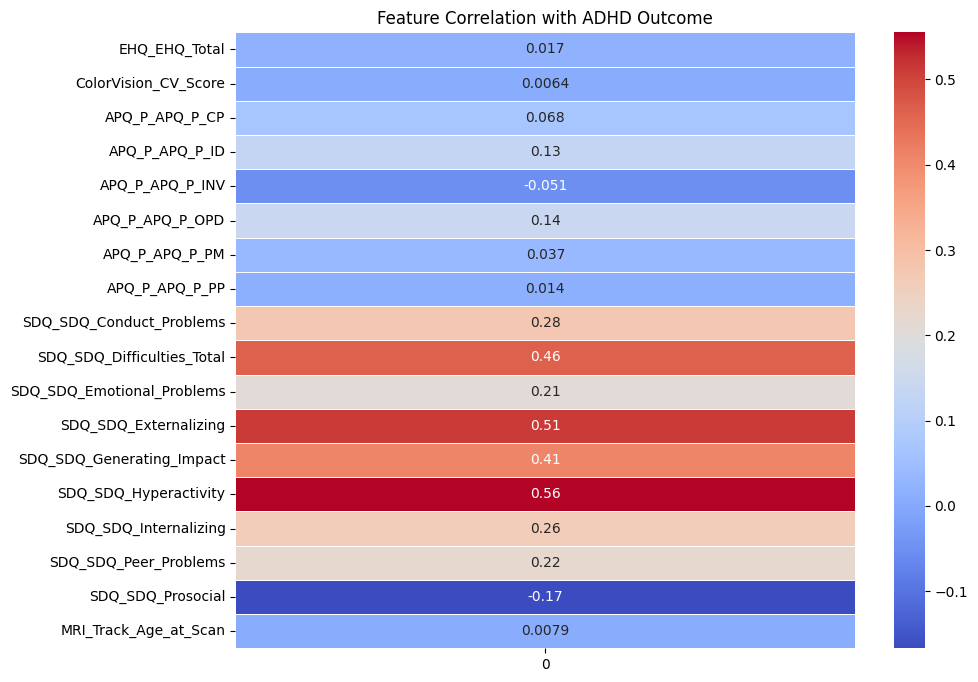

In [ ]:
# Heatmap for correlation visualization
plt.figure(figsize=(10, 8))
sns.heatmap(train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded["ADHD_Outcome"]).to_frame(),
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with ADHD Outcome")
plt.show()

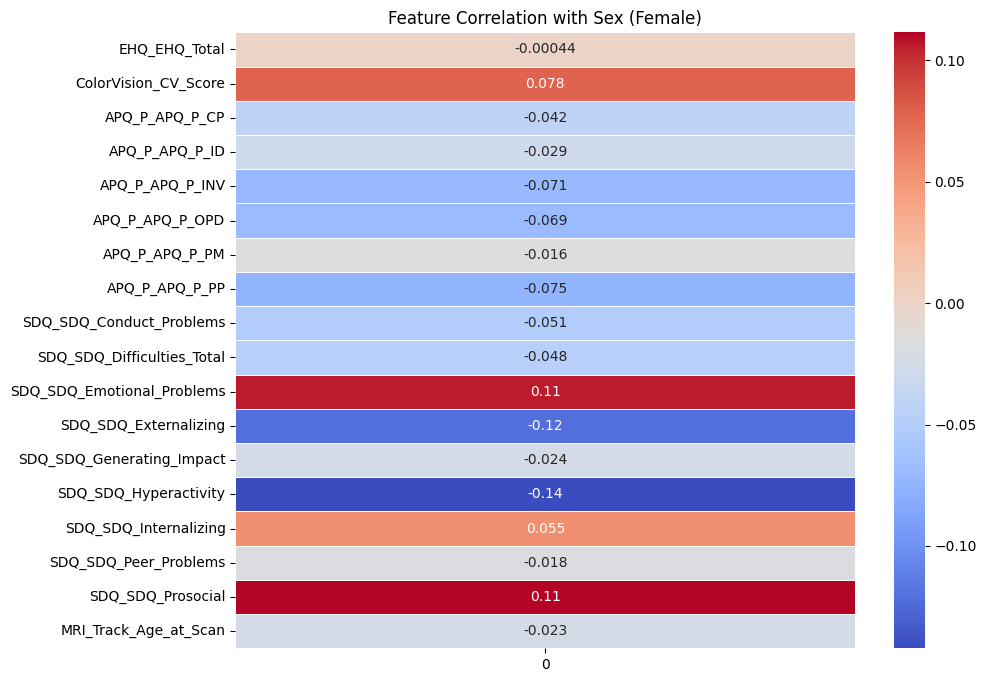

In [ ]:
# Heatmap for correlation visualization
plt.figure(figsize=(10, 8))
sns.heatmap(train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded["Sex_F"]).to_frame(),
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Sex (Female)")
plt.show()

Drop one of feature from each of these pairs:

Highly correlated pairs (>|0.8|):\
SDQ_SDQ_Externalizing and SDQ_SDQ_Difficulties_Total: 0.88\
SDQ_SDQ_Internalizing and SDQ_SDQ_Difficulties_Total: 0.83\
SDQ_SDQ_Internalizing and SDQ_SDQ_Emotional_Problems: 0.83\
SDQ_SDQ_Hyperactivity and SDQ_SDQ_Externalizing: 0.90\
SDQ_SDQ_Peer_Problems and SDQ_SDQ_Internalizing: 0.82

Since SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Emotional_Problems, SDQ_SDQ_Hyperactivity and SDQ_SDQ_Peer_Problems have higher correlation with the labels, we keep them.\
Drop SDQ_SDQ_Externalizing and SDQ_SDQ_Internalizing.

Check if there is still high pairwise correlation

In [ ]:
train_Quant = train_Quant.drop(columns = ['SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing'])

In [ ]:
clean_corr_matrix = train_Quant.iloc[:, 1:].corr()
clean_corr_matrix

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
EHQ_EHQ_Total,1.000000,0.027679,-0.013414,0.019131,0.033819,-0.012423,0.049200,0.020321,-0.051240,-0.054827,-0.034221,-0.014712,-0.005902,-0.079418,-0.003058,0.063955
ColorVision_CV_Score,0.027679,1.000000,0.066965,0.022960,0.007465,0.023402,-0.013446,0.029796,0.016444,0.000335,0.010199,0.051282,-0.003932,-0.020101,-0.009576,-0.061135
APQ_P_APQ_P_CP,-0.013414,0.066965,1.000000,0.315148,0.089254,0.379770,0.138122,0.151907,0.206375,0.187030,0.075342,0.137611,0.165202,0.086405,-0.048402,-0.051431
APQ_P_APQ_P_ID,0.019131,0.022960,0.315148,1.000000,0.063517,0.398303,0.290048,0.141616,0.262340,0.244832,0.179096,0.260136,0.192592,0.069351,-0.209724,0.006457
APQ_P_APQ_P_INV,0.033819,0.007465,0.089254,0.063517,1.000000,0.293751,0.036298,0.739292,-0.150160,-0.135987,-0.053424,-0.062042,-0.068736,-0.133852,0.169940,-0.046899
APQ_P_APQ_P_OPD,-0.012423,0.023402,0.379770,0.398303,0.293751,1.000000,0.172204,0.383299,0.298944,0.273078,0.134797,0.228552,0.209824,0.145343,-0.150646,-0.093420
APQ_P_APQ_P_PM,0.049200,-0.013446,0.138122,0.290048,0.036298,0.172204,1.000000,0.097627,0.085674,0.031272,0.052693,0.081955,-0.036648,0.010564,-0.048129,0.493513
APQ_P_APQ_P_PP,0.020321,0.029796,0.151907,0.141616,0.739292,0.383299,0.097627,1.000000,-0.063663,-0.028697,-0.002789,0.018003,-0.001538,-0.023694,0.095512,-0.030037
SDQ_SDQ_Conduct_Problems,-0.051240,0.016444,0.206375,0.262340,-0.150160,0.298944,0.085674,-0.063663,1.000000,0.725036,0.324690,0.507716,0.454704,0.359604,-0.398833,-0.052581
SDQ_SDQ_Difficulties_Total,-0.054827,0.000335,0.187030,0.244832,-0.135987,0.273078,0.031272,-0.028697,0.725036,1.000000,0.687964,0.717915,0.775414,0.678986,-0.365395,-0.021106


In [ ]:
# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = clean_corr_matrix.where(np.triu(np.ones(clean_corr_matrix.shape), k=1).astype(bool))

# Find pairs of features with a correlation coefficient greater than 0.8
high_corr_pairs = [(col, row, upper_tri.loc[row, col])
                   for row in upper_tri.index
                   for col in upper_tri.columns
                   if pd.notnull(upper_tri.loc[row, col]) and abs(upper_tri.loc[row, col]) > 0.8]

print("Highly correlated pairs (>|0.8|):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Highly correlated pairs (>|0.8|):


Check the remaining features' correlations with the labels

In [ ]:
clean_corr_ADHD = train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded['ADHD_Outcome']).sort_values(ascending=False)
clean_corr_sex = train_Quant.iloc[:, 1:].corrwith(train_Solutions_encoded['Sex_F']).sort_values(ascending=False)
print(corr_ADHD)
print(corr_sex)

SDQ_SDQ_Hyperactivity         0.555330
SDQ_SDQ_Externalizing         0.512610
SDQ_SDQ_Difficulties_Total    0.463507
SDQ_SDQ_Generating_Impact     0.410587
SDQ_SDQ_Conduct_Problems      0.277026
SDQ_SDQ_Internalizing         0.259324
SDQ_SDQ_Peer_Problems         0.221330
SDQ_SDQ_Emotional_Problems    0.207633
APQ_P_APQ_P_OPD               0.142988
APQ_P_APQ_P_ID                0.129692
APQ_P_APQ_P_CP                0.067771
APQ_P_APQ_P_PM                0.036727
EHQ_EHQ_Total                 0.017211
APQ_P_APQ_P_PP                0.013556
MRI_Track_Age_at_Scan         0.007854
ColorVision_CV_Score          0.006376
APQ_P_APQ_P_INV              -0.051462
SDQ_SDQ_Prosocial            -0.166941
dtype: float64
SDQ_SDQ_Prosocial             0.111603
SDQ_SDQ_Emotional_Problems    0.105869
ColorVision_CV_Score          0.078360
SDQ_SDQ_Internalizing         0.054663
EHQ_EHQ_Total                -0.000444
APQ_P_APQ_P_PM               -0.016023
SDQ_SDQ_Peer_Problems        -0.017740
MRI_Track_

Calculate the VIF values for futher multicollinearity check

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Select only numeric columns
train_Quant_numeric = train_Quant.iloc[:, 1:]

train_Quant_vif = pd.DataFrame()
train_Quant_vif['feature'] = train_Quant_numeric.columns
train_Quant_vif['VIF'] = [variance_inflation_factor(train_Quant_numeric.values, i)
                   for i in range(train_Quant_numeric.shape[1])]

train_Quant_vif

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,EHQ_EHQ_Total,2.428604
1,ColorVision_CV_Score,19.275515
2,APQ_P_APQ_P_CP,10.655652
3,APQ_P_APQ_P_ID,17.708621
4,APQ_P_APQ_P_INV,90.438606
5,APQ_P_APQ_P_OPD,37.137083
6,APQ_P_APQ_P_PM,15.917099
7,APQ_P_APQ_P_PP,99.034658
8,SDQ_SDQ_Conduct_Problems,inf
9,SDQ_SDQ_Difficulties_Total,inf


Combine the high VIF features that measure the similar aspects of the same metric.

In [ ]:
# Group highly correlated variables of train_Quant
combined_train_Quant_features = {
    'SDQ_combined': ['SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
                  'SDQ_SDQ_Hyperactivity',  'SDQ_SDQ_Peer_Problems'],
    'APQ_combined': ['APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
                      'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PP',
                     'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_PM']
}

# Create new combined variables for train_Quant
for new_var, old_vars in combined_train_Quant_features.items():
    train_Quant_numeric[new_var] = train_Quant_numeric[old_vars].mean(axis=1)
    train_Quant_numeric.drop(columns=old_vars, inplace=True)

In [ ]:
# Recalculate VIF after combination for train_Quant
train_Quant_vif_reduced = pd.DataFrame()
train_Quant_vif_reduced['feature'] = train_Quant_numeric.columns
train_Quant_vif_reduced['VIF'] = [variance_inflation_factor(train_Quant_numeric.values, i)
                            for i in range(train_Quant_numeric.shape[1])]

print(train_Quant_vif_reduced)

# Add the 'participant_id' column back for future concatenation
train_Quant_final = pd.concat([train_Quant['participant_id'], train_Quant_numeric], axis=1)

                     feature        VIF
0              EHQ_EHQ_Total   2.408692
1       ColorVision_CV_Score  18.812330
2  SDQ_SDQ_Generating_Impact   6.464385
3          SDQ_SDQ_Prosocial  12.763711
4      MRI_Track_Age_at_Scan  16.091976
5               SDQ_combined   9.117694
6               APQ_combined  36.520255


In [ ]:
# Select only numeric columns
test_Quant_numeric = test_Quant.iloc[:, 1:]

test_Quant_vif = pd.DataFrame()
test_Quant_vif['feature'] = test_Quant_numeric.columns
test_Quant_vif['VIF'] = [variance_inflation_factor(test_Quant_numeric.values, i)
                   for i in range(test_Quant_numeric.shape[1])]

test_Quant_vif

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,EHQ_EHQ_Total,2.550675
1,ColorVision_CV_Score,41.155529
2,APQ_P_APQ_P_CP,22.211647
3,APQ_P_APQ_P_ID,20.470275
4,APQ_P_APQ_P_INV,101.524550
5,APQ_P_APQ_P_OPD,41.940147
6,APQ_P_APQ_P_PM,21.231113
7,APQ_P_APQ_P_PP,116.854487
8,SDQ_SDQ_Conduct_Problems,inf
9,SDQ_SDQ_Difficulties_Total,inf


The test_Quant data have the same issue.

In [ ]:
# Group highly correlated variables of train_Quant
combined_test_Quant_features = {
    'SDQ_combined': ['SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
                     'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Hyperactivity',  'SDQ_SDQ_Internalizing',
                     'SDQ_SDQ_Peer_Problems'],
    'APQ_combined': ['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
                      'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP']
}

# Create new combined variables for test_Quant
for new_var, old_vars in combined_test_Quant_features.items():
    test_Quant_numeric[new_var] = test_Quant_numeric[old_vars].mean(axis=1)
    test_Quant_numeric.drop(columns=old_vars, inplace=True)

In [ ]:
# Recalculate VIF after combination for test_Quant
test_Quant_vif_reduced = pd.DataFrame()
test_Quant_vif_reduced['feature'] = test_Quant_numeric.columns
test_Quant_vif_reduced['VIF'] = [variance_inflation_factor(test_Quant_numeric.values, i)
                            for i in range(test_Quant_numeric.shape[1])]

# Add the 'participant_id' column back for future concatenation
test_Quant_final = pd.concat([test_Quant['participant_id'], test_Quant_numeric], axis=1)

print(test_Quant_vif_reduced)

                     feature        VIF
0              EHQ_EHQ_Total   2.480107
1       ColorVision_CV_Score  39.007929
2  SDQ_SDQ_Generating_Impact   7.295980
3          SDQ_SDQ_Prosocial  18.755824
4      MRI_Track_Age_at_Scan  11.370395
5               SDQ_combined  12.218797
6               APQ_combined  59.157349


By combining the features with high VIF (i.e., high correlations among them), we've reduced multicollinearity and retained the predictive power.

In [ ]:
train_Quant_final

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,UmrK0vMLopoR,40.00,13,0,10,10.739219,2.4,18.666667
1,CPaeQkhcjg7d,-94.47,14,7,5,10.739219,7.2,20.166667
2,Nb4EetVPm3gs,-46.67,14,5,9,8.239904,5.6,17.333333
3,p4vPhVu91o4b,-26.68,10,9,6,10.739219,9.6,19.833333
4,M09PXs7arQ5E,0.00,14,4,9,8.940679,7.2,22.000000
...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,3,9,10.697923,3.6,19.000000
1209,groSbUfkQngM,77.80,14,9,7,13.964750,7.2,16.500000
1210,zmxGvIrOD0bt,16.68,14,0,10,10.739219,1.6,18.000000
1211,rOmWFuJCud5G,53.40,14,3,9,12.089094,3.6,19.166667


In [ ]:
test_Quant_final

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,Cfwaf5FX7jWK,60.03,14.0,2.0,8.0,8.992813,5.142857,19.666667
1,vhGrzmvA3Hjq,86.71,12.0,7.0,9.0,12.324093,6.857143,20.000000
2,ULliyEXjy4OV,26.68,13.0,1.0,9.0,7.770933,3.000000,18.000000
3,LZfeAb1xMtql,93.38,13.0,8.0,6.0,9.304814,6.428571,20.833333
4,EnFOUv0YK1RG,-93.38,14.0,5.0,10.0,8.261350,7.714286,20.166667
...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,86.71,14.0,5.0,7.0,7.546999,7.714286,19.000000
300,IUEHiLmQAqCi,73.37,14.0,5.0,8.0,10.531143,6.857143,19.166667
301,cRySmCadYFRO,87.84,13.0,4.0,10.0,7.210586,4.714286,18.666667
302,E3MvDUtJadc5,46.76,14.0,6.0,0.0,12.212183,9.000000,19.000000


## Feature engineer the FMRI data

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Select only numeric columns
train_FCM_numeric = train_FCM.iloc[:, 1:]

In [ ]:
train_FCM_numeric.isnull().sum().sum()

np.int64(0)

In [ ]:
# Standardize the data
scaler = StandardScaler()
train_FCM_scaled = scaler.fit_transform(train_FCM_numeric)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

In [ ]:
Ipca_train_FCM = IncrementalPCA(n_components=100, batch_size=100)

for batch in np.array_split(train_FCM_scaled, 10):  # Split into 10 equal batches
    Ipca_train_FCM.partial_fit(batch)

In [ ]:
train_FCM_pca = Ipca_train_FCM.fit_transform(train_FCM_scaled)

In [ ]:
# Explained variance ratio
explained_var_train_FCM = Ipca_train_FCM.explained_variance_ratio_
cum_var_train_FCM = np.cumsum(explained_var_train_FCM)  # Compute cumulative sum

# Find number of components for 95% variance
n_95_train_FCM = np.argmax(cum_var_train_FCM >= 0.95)
print(f"Number of components explaining 95% variance: {n_95_train_FCM}")

Number of components explaining 95% variance: 0


In [ ]:
explained_var_train_FCM

array([0.00412107, 0.00288766, 0.00254326, 0.00222711, 0.00214542,
       0.00196695, 0.00193623, 0.00191994, 0.00190081, 0.00188088,
       0.00186499, 0.00185351, 0.00183963, 0.00182513, 0.00181801,
       0.00180531, 0.00179366, 0.00179192, 0.00178654, 0.00177205,
       0.00176883, 0.0017606 , 0.0017504 , 0.00174209, 0.00173708,
       0.00172681, 0.00171557, 0.00170957, 0.00170605, 0.00170131,
       0.00168827, 0.0016802 , 0.00167606, 0.00166746, 0.00166672,
       0.00166186, 0.00164789, 0.00164369, 0.00163392, 0.00162522,
       0.0016168 , 0.00160585, 0.00160401, 0.00160111, 0.00159154,
       0.00158352, 0.00157801, 0.0015665 , 0.00156138, 0.00155257,
       0.00153606, 0.00152762, 0.00152452, 0.00152071, 0.00151365,
       0.00150626, 0.00148588, 0.00147822, 0.00147007, 0.00146693,
       0.00142779, 0.00138395, 0.00136457, 0.00134594, 0.00132854,
       0.00132022, 0.00129963, 0.00128941, 0.00128493, 0.00128165,
       0.00127646, 0.001274  , 0.00126605, 0.00126338, 0.00126

In [ ]:
top_10_indices = np.argsort(explained_var_train_FCM)[::-1][:]  # Sort and select top 10

total_explained_variance = np.sum(explained_var_train_FCM[top_10_indices])
print(f"Total explained variance by top 10 components: {total_explained_variance}")

Total explained variance by top 10 components: 0.1564560020389455


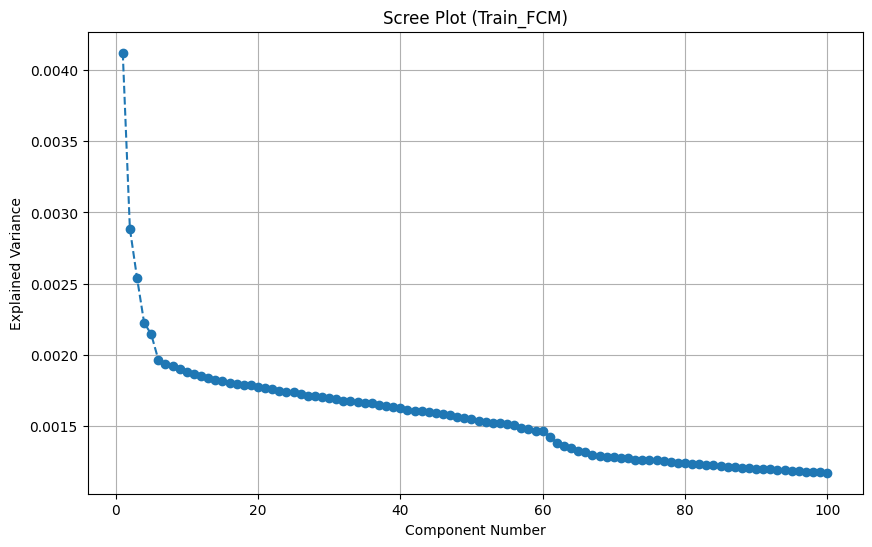

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var_train_FCM) + 1), explained_var_train_FCM, marker='o', linestyle='--')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.title('Scree Plot (Train_FCM)')
plt.grid()
plt.show()

We've increased the variance explained by features and reduced the dimension of features.

In [ ]:
# Convert the PCA results into a DataFrame and name the columns
train_FCM_pca_df = pd.DataFrame(train_FCM_pca, columns=[f'FCM_pca{i+1}' for i in range(train_FCM_pca.shape[1])])

# Add participant_id from the original train_FCM DataFrame
train_FCM_pca_df.insert(0, 'participant_id', train_FCM['participant_id'])

train_FCM_pca_df

,participant_id,FCM_pca1,FCM_pca2,FCM_pca3,FCM_pca4,FCM_pca5,FCM_pca6,FCM_pca7,FCM_pca8,FCM_pca9,...,FCM_pca91,FCM_pca92,FCM_pca93,FCM_pca94,FCM_pca95,FCM_pca96,FCM_pca97,FCM_pca98,FCM_pca99,FCM_pca100
0,70z8Q2xdTXM3,-2.104216,1.527871,-5.472044,-1.501128,-3.109377,2.290825,-2.070595,2.735548,1.438040,...,-3.472041,1.345582,-0.421574,0.940855,0.329486,-1.854666,3.019328,2.931555,2.921463,-4.095593
1,WHWymJu6zNZi,-10.837748,9.682127,-2.638755,-1.262511,-1.795360,4.699595,-0.047910,-0.258187,-0.070838,...,5.017107,1.616304,6.313307,0.771306,0.414887,12.896766,-6.585975,1.657009,6.883951,4.860787
2,4PAQp1M6EyAo,-3.535884,11.951715,3.753685,-2.165347,-0.797893,-1.398461,0.716563,1.218711,-1.023355,...,2.254314,1.067558,1.731724,-0.795983,-2.060911,-1.509118,-0.963169,-0.062228,1.055890,-0.612073
3,obEacy4Of68I,3.393520,-10.325654,-0.602929,1.208491,1.021298,-0.878289,-0.061652,0.268189,0.307585,...,1.040120,-5.547765,1.109669,4.069127,-4.342501,-0.351658,-3.159234,0.174785,-1.277741,-0.726903
4,s7WzzDcmDOhF,-9.194587,1.814165,4.850313,-1.269607,-1.707222,-0.428166,-4.758264,-0.242951,1.472851,...,7.887311,-0.491861,0.919353,2.388054,-3.690742,-1.968327,-5.588327,-6.632971,-3.088451,2.469136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,kTurROKp5YHQ,-5.034501,3.716839,4.985219,1.445705,-2.163715,-0.827420,0.264324,2.084541,-0.121445,...,-4.111501,0.279317,-1.834804,-3.080215,3.078125,0.035825,-1.060053,2.842159,0.686264,-0.543034
1209,FCRyMz9O6yCq,-2.740722,5.648879,9.398410,7.481512,0.622134,-4.168966,4.156955,1.852373,-0.975991,...,-1.984578,-0.706153,3.328354,5.100188,1.031775,-2.711850,1.064021,-1.546132,-5.311887,0.881708
1210,vm2P1hmAY1hl,-4.480768,-6.279360,4.970240,-3.847728,-4.656433,-3.726044,-6.364118,0.640378,4.409666,...,6.686683,8.039143,-9.271338,7.638550,-3.115669,0.941461,-3.484158,4.027231,-4.598013,-1.025415
1211,OFxvN8lnw21w,1.897395,-5.572589,-13.623484,5.846009,2.235731,-1.785370,-0.219388,0.570936,3.330942,...,0.357019,0.111903,-1.311812,0.435253,-2.979689,4.287556,-0.190269,-0.077271,-3.855758,4.420252


Do the same to the test_FCM dataframe

In [ ]:
# Select only numeric columns
test_FCM_numeric = test_FCM.iloc[:, 1:]

In [ ]:
test_FCM_numeric.isnull().sum().sum()

np.int64(0)

In [ ]:
# Standardize the data
scaler = StandardScaler()
test_FCM_scaled = scaler.fit_transform(test_FCM_numeric)

Ipca_test_FCM = IncrementalPCA(n_components=30, batch_size=100)

for batch in np.array_split(test_FCM_scaled, 10):  # Split into 10 equal batches
    Ipca_test_FCM.partial_fit(batch)

test_FCM_pca = Ipca_test_FCM.fit_transform(test_FCM_scaled)

In [ ]:
# Explained variance ratio
explained_var_test_FCM = Ipca_test_FCM.explained_variance_ratio_
cum_var_test_FCM = np.cumsum(explained_var_test_FCM)  # Compute cumulative sum

# Find number of components for 95% variance
n_95_test_FCM = np.argmax(cum_var_test_FCM >= 0.95)
print(f"Number of components explaining 95% variance: {n_95_test_FCM}")

Number of components explaining 95% variance: 0


In [ ]:
explained_var_test_FCM

array([0.09303358, 0.02819404, 0.02564892, 0.02213992, 0.01694555,
       0.01609698, 0.01318206, 0.0116632 , 0.01148749, 0.01029353,
       0.00962302, 0.00923161, 0.00836744, 0.00820661, 0.00808315,
       0.00796377, 0.00748734, 0.00723286, 0.00710908, 0.00692515,
       0.00680963, 0.0064918 , 0.00608073, 0.00601471, 0.00581521,
       0.0056872 , 0.00548855, 0.00536448, 0.00527778, 0.00515019])

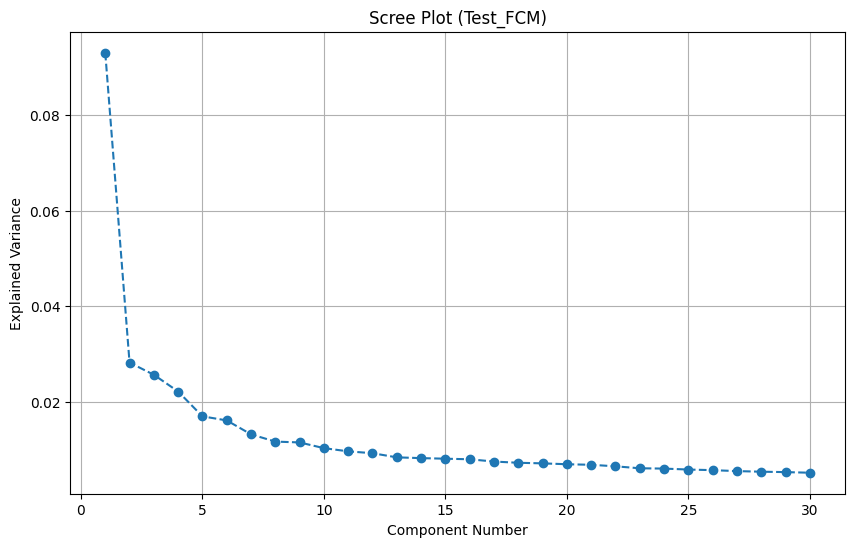

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var_test_FCM) + 1), explained_var_test_FCM, marker='o', linestyle='--')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.title('Scree Plot (Test_FCM)')
plt.grid()
plt.show()

In [ ]:
# Convert the PCA results into a DataFrame and name the columns
test_FCM_pca_df = pd.DataFrame(test_FCM_pca, columns=[f'FCM_pca{i+1}' for i in range(test_FCM_pca.shape[1])])

# Add participant_id from the original train_FCM DataFrame
test_FCM_pca_df.insert(0, 'participant_id', test_FCM['participant_id'])

test_FCM_pca_df

,participant_id,FCM_pca1,FCM_pca2,FCM_pca3,FCM_pca4,FCM_pca5,FCM_pca6,FCM_pca7,FCM_pca8,FCM_pca9,...,FCM_pca21,FCM_pca22,FCM_pca23,FCM_pca24,FCM_pca25,FCM_pca26,FCM_pca27,FCM_pca28,FCM_pca29,FCM_pca30
0,Cfwaf5FX7jWK,-1.607276,1.786551,18.159569,12.840566,8.869429,-9.166262,9.524351,17.025512,-0.421605,...,-8.674147,8.698093,-4.051248,8.027402,1.294848,8.088702,-4.181819,5.631320,-8.119787,-4.571687
1,vhGrzmvA3Hjq,-28.598541,-13.436526,9.983910,18.191972,13.582766,17.273424,4.263868,6.288980,-4.627881,...,-1.702462,-7.981421,2.052021,18.133551,28.046660,-15.878492,1.241544,2.571810,-15.227753,6.213582
2,ULliyEXjy4OV,-5.172909,3.603131,-4.858944,-28.259016,-13.978398,4.777415,-9.898916,-13.092751,-6.593767,...,-7.956112,-17.602312,11.592405,0.954652,5.479493,4.072986,-3.578303,-3.975605,-3.334790,-10.459410
3,LZfeAb1xMtql,-7.422387,-11.520470,11.896539,-5.930781,2.834677,5.290578,-11.414956,-0.233565,1.475247,...,-4.120161,-2.531034,1.794069,-13.647243,3.088984,0.869050,-6.646916,-9.329819,-1.293256,-2.909764
4,EnFOUv0YK1RG,14.893905,-4.051520,8.716727,0.295122,-13.073078,5.184284,1.411099,-4.581677,-5.348623,...,1.697496,-13.873783,2.365518,4.788291,3.248877,-8.524875,2.908064,1.726072,12.867987,11.532528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,21.360345,-28.050939,36.281343,-6.112487,7.517485,-0.922223,-2.406077,-1.732872,-4.056307,...,10.862045,2.081249,-3.843744,-3.305502,6.929675,-2.795645,-0.968596,10.165215,19.509352,6.352460
300,IUEHiLmQAqCi,-19.411930,-5.552517,-7.274177,28.726593,4.949239,17.265937,1.499756,-2.521755,-17.568685,...,14.423899,5.314328,-17.261237,5.161571,13.137747,13.767649,5.668257,0.315070,11.431883,3.758609
301,cRySmCadYFRO,3.674557,-18.328731,29.177113,10.822565,10.855559,-0.605361,12.276894,17.214165,-25.652426,...,2.417902,2.991226,-11.129564,-2.411347,1.219209,0.515084,-2.573483,8.402454,-0.622655,-1.596001
302,E3MvDUtJadc5,-37.609527,2.022720,17.424167,-7.511578,-28.616378,-36.632022,-22.050465,-27.877396,16.155092,...,-0.570372,6.818581,5.492894,-6.611928,8.578845,-5.100307,13.344185,-5.074969,2.941424,-21.199957


## One-Hot Encoding

One hot encoding is only possible on categorical variables so the first step is to switch our integer representations into category type variables.

In [ ]:
for col in train_cat.select_dtypes(include='int').columns:
    train_cat[col] = train_cat[col].astype('category')

Our first column of our dataset is our participant id. This is an indicator variable that identifies each patient. This column is very important as it will be the one used to merge all of our data frames together, but, we do not want to encode this column. So, we will create a list of all the columns except the first one and label those `columns_to_encode`.

In [ ]:
# Creating a list of all of the columns except the first
columns_to_encode = train_cat.columns[1:].tolist()

# Apply one-hot encoding to train_cat
train_cat_encoded = pd.get_dummies(train_cat, columns=columns_to_encode, drop_first=True)

# Print the columns to encode
print("Columns to encode:", columns_to_encode)

# Encode categorical data
train_cat_encoded = train_cat_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


<ipython-input-87-afe73d9f1e9c>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_cat_encoded = train_cat_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [ ]:
# Combine encoded columns with the rest of the DataFrame
train_cat_final = pd.concat([train_cat.drop(columns=columns_to_encode), train_cat_encoded], axis=1)

# Extract participant_id as a separate DataFrame to avoid duplication
participant_id_col = train_cat[['participant_id']].copy()

# Ensure 'participant_id' is NOT in train_cat_encoded
train_cat_encoded = train_cat_encoded.drop(columns=['participant_id'], errors='ignore')

# Now concatenate safely
train_cat_final = pd.concat([participant_id_col, train_cat_encoded], axis=1)

# Ensure it looks correct
train_cat_final

,participant_id,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,PreInt_Demos_Fam_Child_Ethnicity_1.0,...,Barratt_Barratt_P2_Edu_21,Barratt_Barratt_P2_Occ_5,Barratt_Barratt_P2_Occ_10,Barratt_Barratt_P2_Occ_15,Barratt_Barratt_P2_Occ_20,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45
0,UmrK0vMLopoR,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,CPaeQkhcjg7d,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Nb4EetVPm3gs,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,p4vPhVu91o4b,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M09PXs7arQ5E,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1209,groSbUfkQngM,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1210,zmxGvIrOD0bt,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1211,rOmWFuJCud5G,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# List of columns to change
columns_to_change = [
    'PreInt_Demos_Fam_Child_Ethnicity_1.0',
    'PreInt_Demos_Fam_Child_Ethnicity_2.0',
    'PreInt_Demos_Fam_Child_Ethnicity_3.0'
]

# Rename the columns by removing '.0'
train_cat_final.columns = [
    col.replace('.0', '') if col in columns_to_change else col
    for col in train_cat_final.columns
]

In [ ]:
train_cat_final.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year_2016',
       'Basic_Demos_Enroll_Year_2017', 'Basic_Demos_Enroll_Year_2018',
       'Basic_Demos_Enroll_Year_2019', 'Basic_Demos_Enroll_Year_2020',
       'Basic_Demos_Study_Site_2', 'Basic_Demos_Study_Site_3',
       'Basic_Demos_Study_Site_4', 'PreInt_Demos_Fam_Child_Ethnicity_1',
       'PreInt_Demos_Fam_Child_Ethnicity_2',
       'PreInt_Demos_Fam_Child_Ethnicity_3', 'PreInt_Demos_Fam_Child_Race_1',
       'PreInt_Demos_Fam_Child_Race_2', 'PreInt_Demos_Fam_Child_Race_3',
       'PreInt_Demos_Fam_Child_Race_4', 'PreInt_Demos_Fam_Child_Race_7',
       'PreInt_Demos_Fam_Child_Race_8', 'PreInt_Demos_Fam_Child_Race_9',
       'PreInt_Demos_Fam_Child_Race_10', 'PreInt_Demos_Fam_Child_Race_11',
       'MRI_Track_Scan_Location_1', 'MRI_Track_Scan_Location_2',
       'MRI_Track_Scan_Location_3', 'MRI_Track_Scan_Location_4',
       'Barratt_Barratt_P1_Edu_3', 'Barratt_Barratt_P1_Edu_6',
       'Barratt_Barratt_P1_Edu_9', 'Barratt_Barratt_P1_

We have just encoded the categorical dataframe for our training data. Now, we need to apply the same encoding steps to the categorical dataframe in the testing data. It's essential to ensure that any preprocessing done on the training data is also applied to the test data to ensure accurate model predictions.

Encode the `test_cat` dataframe

In [ ]:
from sklearn.preprocessing import LabelEncoder as encoder

In [ ]:
# Apply pd.get_dummies to the test set
test_cat_encoded = pd.get_dummies(test_cat[columns_to_encode], drop_first=True)

# Ensure missing columns in test_cat_encoded are filled with 0 (columns not in test data but present in training data)
missing_cols = set(train_cat_encoded.columns) - set(test_cat_encoded.columns)
for col in missing_cols:
    test_cat_encoded[col] = 0

# Ensure extra columns are removed (in case test data has extra categories)
test_cat_encoded = test_cat_encoded[train_cat_encoded.columns]

# Combine with the rest of the test DataFrame (excluding original categorical columns)
test_cat_final = pd.concat([test_cat.drop(columns=columns_to_encode), test_cat_encoded], axis=1)

test_cat_final

,participant_id,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,PreInt_Demos_Fam_Child_Ethnicity_1.0,...,Barratt_Barratt_P2_Edu_21,Barratt_Barratt_P2_Occ_5,Barratt_Barratt_P2_Occ_10,Barratt_Barratt_P2_Occ_15,Barratt_Barratt_P2_Occ_20,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45
0,Cfwaf5FX7jWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vhGrzmvA3Hjq,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ULliyEXjy4OV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LZfeAb1xMtql,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,EnFOUv0YK1RG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,IUEHiLmQAqCi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,cRySmCadYFRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
302,E3MvDUtJadc5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for col in test_cat.select_dtypes(include='int').columns:
    test_cat[col] = test_cat[col].astype('category')

# Creating a list of all of the columns except the first
columns_to_encode = test_cat.columns[1:].tolist()

# Apply one-hot encoding to train_cat
test_cat_encoded = pd.get_dummies(test_cat, columns=columns_to_encode, drop_first=True)

# Print the columns to encode
print("Columns to encode:", columns_to_encode)

# Encode categorical data
test_cat_encoded = test_cat_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Combine encoded columns with the rest of the DataFrame
test_cat_final = pd.concat([test_cat.drop(columns=columns_to_encode), test_cat_encoded], axis=1)

# Extract participant_id as a separate DataFrame to avoid duplication
participant_id_col = test_cat[['participant_id']].copy()

# Ensure 'participant_id' is NOT in train_cat_encoded
test_cat_encoded = test_cat_encoded.drop(columns=['participant_id'], errors='ignore')

# Now concatenate safely
test_cat_final = pd.concat([participant_id_col, test_cat_encoded], axis=1)

# Ensure it looks correct
test_cat_final

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


<ipython-input-93-4938d0fe11df>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_cat_encoded = test_cat_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


,participant_id,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_1.0,PreInt_Demos_Fam_Child_Ethnicity_2.0,PreInt_Demos_Fam_Child_Ethnicity_3.0,PreInt_Demos_Fam_Child_Race_1.0,...,Barratt_Barratt_P2_Edu_21.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0
0,Cfwaf5FX7jWK,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,vhGrzmvA3Hjq,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,ULliyEXjy4OV,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,LZfeAb1xMtql,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,EnFOUv0YK1RG,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
300,IUEHiLmQAqCi,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
301,cRySmCadYFRO,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
302,E3MvDUtJadc5,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
# List of columns to change
columns_to_change = [
    'PreInt_Demos_Fam_Child_Ethnicity_1.0',
    'PreInt_Demos_Fam_Child_Ethnicity_2.0',
    'PreInt_Demos_Fam_Child_Ethnicity_3.0'
]

# Rename the columns by removing '.0'
test_cat_final.columns = [
    col.replace('.0', '') if col in columns_to_change else col
    for col in test_cat_final.columns
]

In [ ]:
test_cat_final.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year_2020',
       'Basic_Demos_Enroll_Year_2021', 'Basic_Demos_Enroll_Year_2022',
       'Basic_Demos_Enroll_Year_2023', 'Basic_Demos_Study_Site_5',
       'PreInt_Demos_Fam_Child_Ethnicity_1',
       'PreInt_Demos_Fam_Child_Ethnicity_2',
       'PreInt_Demos_Fam_Child_Ethnicity_3', 'PreInt_Demos_Fam_Child_Race_1.0',
       'PreInt_Demos_Fam_Child_Race_2.0', 'PreInt_Demos_Fam_Child_Race_3.0',
       'PreInt_Demos_Fam_Child_Race_4.0', 'PreInt_Demos_Fam_Child_Race_7.0',
       'PreInt_Demos_Fam_Child_Race_8.0', 'PreInt_Demos_Fam_Child_Race_9.0',
       'PreInt_Demos_Fam_Child_Race_11.0', 'MRI_Track_Scan_Location_4',
       'Barratt_Barratt_P1_Edu_6.0', 'Barratt_Barratt_P1_Edu_9.0',
       'Barratt_Barratt_P1_Edu_12.0', 'Barratt_Barratt_P1_Edu_15.0',
       'Barratt_Barratt_P1_Edu_18.0', 'Barratt_Barratt_P1_Edu_21.0',
       'Barratt_Barratt_P1_Occ_5.0', 'Barratt_Barratt_P1_Occ_15.0',
       'Barratt_Barratt_P1_Occ_20.0', 'Barratt_Barratt_P1_O

### Merge training dataframes


All the dataframes include a **participant_id variable,** which serves as the unique identifier for each patient. **This variable will be used to merge the dataframes, as it is the only common variable across the datasets.**

The pandas merge function can only merge two dataframes. So, I will first merge our encoded train categorical dataframe with our training functional connectome matrices. Then I will combine that merged data frame with our training quantitative dataframe. Again, this will all be executed using the pandas merge function on our participant id variable.

In [ ]:
train_cat_FCM = pd.merge(train_cat_final, train_FCM_pca_df, on = 'participant_id')

In [ ]:
train_df = pd.concat([train_cat_FCM, train_Quant_final])

# Ensure it looks accurate
train_df

,participant_id,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,PreInt_Demos_Fam_Child_Ethnicity_1,...,FCM_pca98,FCM_pca99,FCM_pca100,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,UmrK0vMLopoR,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.514356,-1.533520,-6.138565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPaeQkhcjg7d,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-0.465061,0.878581,1.580741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nb4EetVPm3gs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,10.776878,14.201202,-0.581249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p4vPhVu91o4b,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.763693,-4.018933,-1.397595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M09PXs7arQ5E,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-3.794160,2.936753,1.074865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,87.80,14.0,3.0,9.0,10.697923,3.6,19.000000
1209,groSbUfkQngM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.80,14.0,9.0,7.0,13.964750,7.2,16.500000
1210,zmxGvIrOD0bt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16.68,14.0,0.0,10.0,10.739219,1.6,18.000000
1211,rOmWFuJCud5G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,53.40,14.0,3.0,9.0,12.089094,3.6,19.166667



This creates an almost complete train dataframe. You may have noticed that there is one dataframe left in our training data that we have not merged, the solutions. When training a machine learning model you have an `X_train ` dataframe containing the feature variables and a `Y_train` dataframe containing the target variables. We just created our `X_train` dataframe. In our third workshop we will cover how to use the `X_train` and `Y_train` dataframes to train the model.

Our testing data does not contain solutions, since that is what you will produce when running your model. So we just need one feature variable dataframe.

We will merge together the feature variables for our testing data, the same way we did for our training data. First, I will load in the quantative and functional connectome matrices.

### Merge testing dataframes

In [ ]:
test_cat_FCM = pd.merge(test_cat_final, test_FCM_pca_df, on = 'participant_id')

test_df = pd.concat([test_cat_FCM, test_Quant_final])

# ensure it looks accurate
test_df

,participant_id,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,PreInt_Demos_Fam_Child_Race_1.0,...,FCM_pca28,FCM_pca29,FCM_pca30,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,Cfwaf5FX7jWK,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.631320,-8.119787,-4.571687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vhGrzmvA3Hjq,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.571810,-15.227753,6.213582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ULliyEXjy4OV,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.975605,-3.334790,-10.459410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LZfeAb1xMtql,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-9.329819,-1.293256,-2.909764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EnFOUv0YK1RG,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.726072,12.867987,11.532528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,86.71,14.0,5.0,7.0,7.546999,7.714286,19.000000
300,IUEHiLmQAqCi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,73.37,14.0,5.0,8.0,10.531143,6.857143,19.166667
301,cRySmCadYFRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,87.84,13.0,4.0,10.0,7.210586,4.714286,18.666667
302,E3MvDUtJadc5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,46.76,14.0,6.0,0.0,12.212183,9.000000,19.000000


## Handle missing data in the whole training/testing set

Fill the missing (`NA`) values using the mean of each column as an example.

Note: There are many approaches to handle missing values, and the best method often depends on your dataset and chosen machine learning model. You can explore how your model deals with missing data and try alternative techniques. For example, this [website](https://www.widsworldwide.org/get-inspired/blog/a-data-scientists-deep-dive-into-the-wids-datathon/) has various ways to handle missing data.

Filling NA values is a key challenge in this datathon to get accurate model performance. Experiment with different methods and evaluate which approach gives the best results for your model!

In [ ]:
train_cat_FCM.reset_index(drop=True, inplace=True)
train_Quant_final.reset_index(drop=True, inplace=True)
train_df = pd.concat([train_cat_FCM, train_Quant_final], axis=1)

In [ ]:
# Check how many NA values we have
train_df.isna().sum()

,0
participant_id,0
Basic_Demos_Enroll_Year_2016,0
Basic_Demos_Enroll_Year_2017,0
Basic_Demos_Enroll_Year_2018,0
Basic_Demos_Enroll_Year_2019,0
...,...
SDQ_SDQ_Generating_Impact,0
SDQ_SDQ_Prosocial,0
MRI_Track_Age_at_Scan,0
SDQ_combined,0


We can fill the missing (`NA`) values in the columns `MRI_Track_Age_at_Scan` by replacing it with its mean.

In [ ]:
train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)
print(train_df.isna().sum().sum()) # should now be zero

0


Use backward and forward fills to handle missing data in the training dataframe. This indicates using previous or the following data row in order to replace the missing values.


In [ ]:
train_df.ffill(inplace=True)
print(train_df.isna().sum().sum())

0


In [ ]:
train_df

,participant_id,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,PreInt_Demos_Fam_Child_Ethnicity_1,...,FCM_pca99,FCM_pca100,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,UmrK0vMLopoR,1,0,0,0,0,0,0,0,0,...,-1.533520,-6.138565,UmrK0vMLopoR,40.00,13,0,10,10.739219,2.4,18.666667
1,CPaeQkhcjg7d,0,0,0,1,0,0,1,0,1,...,0.878581,1.580741,CPaeQkhcjg7d,-94.47,14,7,5,10.739219,7.2,20.166667
2,Nb4EetVPm3gs,1,0,0,0,0,0,0,0,1,...,14.201202,-0.581249,Nb4EetVPm3gs,-46.67,14,5,9,8.239904,5.6,17.333333
3,p4vPhVu91o4b,0,0,1,0,0,0,1,0,0,...,-4.018933,-1.397595,p4vPhVu91o4b,-26.68,10,9,6,10.739219,9.6,19.833333
4,M09PXs7arQ5E,0,0,0,1,0,0,1,0,0,...,2.936753,1.074865,M09PXs7arQ5E,0.00,14,4,9,8.940679,7.2,22.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,0,0,0,1,0,0,0,0,0,...,-0.506103,0.231762,Atx7oub96GXS,87.80,14,3,9,10.697923,3.6,19.000000
1209,groSbUfkQngM,1,0,0,0,0,0,0,0,0,...,-19.669332,-8.578858,groSbUfkQngM,77.80,14,9,7,13.964750,7.2,16.500000
1210,zmxGvIrOD0bt,0,0,0,0,0,0,0,0,1,...,4.181058,-13.019344,zmxGvIrOD0bt,16.68,14,0,10,10.739219,1.6,18.000000
1211,rOmWFuJCud5G,0,0,1,0,0,0,1,0,0,...,2.262998,-2.720790,rOmWFuJCud5G,53.40,14,3,9,12.089094,3.6,19.166667


In [ ]:
test_cat_FCM.reset_index(drop=True, inplace=True)
test_Quant_final.reset_index(drop=True, inplace=True)
test_df = pd.concat([test_cat_FCM, test_Quant_final], axis=1)

In [ ]:
# Identify all 'participant_id' columns
participant_id_cols = [col for col in test_df.columns if col == 'participant_id']

# If there are multiple, drop all except the first one
if len(participant_id_cols) > 1:
    test_df = test_df.loc[:, ~test_df.columns.duplicated()]

In [ ]:
test_df.isna().sum().sum()

np.int64(0)

In [ ]:
test_df

,participant_id,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,PreInt_Demos_Fam_Child_Race_1.0,...,FCM_pca28,FCM_pca29,FCM_pca30,EHQ_EHQ_Total,ColorVision_CV_Score,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,SDQ_combined,APQ_combined
0,Cfwaf5FX7jWK,0,0,1,0,0,0,0,0,0,...,5.631320,-8.119787,-4.571687,60.03,14.0,2.0,8.0,8.992813,5.142857,19.666667
1,vhGrzmvA3Hjq,0,0,0,1,0,0,0,0,0,...,2.571810,-15.227753,6.213582,86.71,12.0,7.0,9.0,12.324093,6.857143,20.000000
2,ULliyEXjy4OV,0,0,1,0,0,0,0,0,0,...,-3.975605,-3.334790,-10.459410,26.68,13.0,1.0,9.0,7.770933,3.000000,18.000000
3,LZfeAb1xMtql,0,0,1,0,0,0,0,0,0,...,-9.329819,-1.293256,-2.909764,93.38,13.0,8.0,6.0,9.304814,6.428571,20.833333
4,EnFOUv0YK1RG,0,0,1,0,0,0,1,0,0,...,1.726072,12.867987,11.532528,-93.38,14.0,5.0,10.0,8.261350,7.714286,20.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,0,0,0,1,0,0,0,0,0,...,10.165215,19.509352,6.352460,86.71,14.0,5.0,7.0,7.546999,7.714286,19.000000
300,IUEHiLmQAqCi,0,0,0,1,0,0,0,0,1,...,0.315070,11.431883,3.758609,73.37,14.0,5.0,8.0,10.531143,6.857143,19.166667
301,cRySmCadYFRO,0,0,0,1,0,0,0,0,0,...,8.402454,-0.622655,-1.596001,87.84,13.0,4.0,10.0,7.210586,4.714286,18.666667
302,E3MvDUtJadc5,0,0,1,0,0,0,0,0,0,...,-5.074969,2.941424,-21.199957,46.76,14.0,6.0,0.0,12.212183,9.000000,19.000000


# Machine Learning Model

## XGBoost & Regularization

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# Split Features & labels
X_train = train_df.drop(columns=['participant_id'])  # training features
y_train = train_Solutions_encoded[['ADHD_Outcome', 'Sex_F']]  # Target lebels

# Define XGBoost Classifier with regularization
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,          # number of boosting rounds
    learning_rate=0.05,        # learning rate
    max_depth=5,               # tree depth
    reg_alpha=0.5,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    subsample=0.8,             # random sampling of training data
    colsample_bytree=0.8,      # random sampling of features
    eval_metric='logloss'
)

In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Test the model
X_test = test_df.drop(columns=['participant_id'])

In [ ]:
# Add missing columns in X_train and X_test, with NaN values
missing_train_cols = list(set(X_test.columns) - set(X_train.columns))
missing_test_cols = list(set(X_train.columns) - set(X_test.columns))

# Create DataFrames for the missing columns
train_missing = pd.DataFrame(np.nan, index=X_train.index, columns=missing_train_cols)
test_missing = pd.DataFrame(np.nan, index=X_test.index, columns=missing_test_cols)

# Concatenate the missing columns to the original DataFrames
X_train = pd.concat([X_train, train_missing], axis=1)
X_test = pd.concat([X_test, test_missing], axis=1)

# Ensure the columns are in the same order
X_train = X_train[X_test.columns]

In [ ]:
# Ensure X_test has the same columns as X_train in the same order
X_test = X_test[X_train.columns]

# Get the feature names from the trained model
model_columns = xgb_model.get_booster().feature_names

# Ensure that the order of X_train and model_columns is the same
X_train = X_train[model_columns]

# Ensure X_test is also ordered to match the model's expected feature order
X_test = X_test[model_columns]

In [ ]:
# Check if the columns in X_train, X_test, and the model are the same
assert list(X_train.columns) == list(X_test.columns), "X_train and X_test columns don't match"
assert list(X_train.columns) == model_columns, "Model and X_train columns don't match"

In [ ]:
y_test_pred = xgb_model.predict(X_test)

In [ ]:
participant_id = test_df['participant_id']

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(
    y_test_pred,
    columns=['Predicted_Sex', 'Predicted_ADHD']
)

predictions_df['Predicted_Sex'] = predictions_df['Predicted_Sex'].astype(int)
predictions_df['Predicted_ADHD'] = predictions_df['Predicted_ADHD'].astype(int)

# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1)

# Print or save the DataFrame
print(result_df)

    participant_id  Predicted_Sex  Predicted_ADHD
0     Cfwaf5FX7jWK              0               1
1     vhGrzmvA3Hjq              1               0
2     ULliyEXjy4OV              0               0
3     LZfeAb1xMtql              1               0
4     EnFOUv0YK1RG              1               0
..             ...            ...             ...
299   UadZfjdEg7eG              1               0
300   IUEHiLmQAqCi              1               0
301   cRySmCadYFRO              0               0
302   E3MvDUtJadc5              1               0
303   dQJXfyRazknD              0               0

[304 rows x 3 columns]


In [ ]:
result_df.to_csv('test_WiDS.csv')